In [2]:
import requests
import pandas as pd
import geopandas as gpd
from io import BytesIO
from zipfile import ZipFile

# ============================================
# STEP 1: Fetch ACS 5-Year Median Income Data
# ============================================

print("📡 Fetching ACS 5-Year 2023 median household income data for LA County...")

base_url = "https://api.census.gov/data/2023/acs/acs5"
get_vars = ["NAME", "B19013_001E"]  # Median household income
params = {
    "get": ",".join(get_vars),
    "for": "tract:*",
    "in": "state:06+county:037"  # California, Los Angeles County
}

response = requests.get(base_url, params=params)
response.raise_for_status()

data = response.json()
columns = data[0]
rows = data[1:]
income_df = pd.DataFrame(rows, columns=columns)

# Clean and convert data types
income_df["B19013_001E"] = pd.to_numeric(income_df["B19013_001E"], errors="coerce")
income_df["GEOID"] = income_df["state"] + income_df["county"] + income_df["tract"]

print(f"✅ Retrieved {len(income_df)} census tracts of income data")

# ============================================
# STEP 2: Download Census Tract Shapefile
# ============================================

print("🗺️ Downloading LA County Census Tract shapefile (TIGER/Line)...")

# TIGER/Line URL for 2023 tracts, California (state FIPS 06)
shapefile_url = "https://www2.census.gov/geo/tiger/TIGER2023/TRACT/tl_2023_06_tract.zip"

r = requests.get(shapefile_url)
r.raise_for_status()

# Extract ZIP in memory
with ZipFile(BytesIO(r.content)) as z:
    z.extractall("tl_2023_06_tract")

tracts_gdf = gpd.read_file("tl_2023_06_tract/tl_2023_06_tract.shp")

# Filter for Los Angeles County (FIPS 037)
tracts_gdf = tracts_gdf[tracts_gdf["COUNTYFP"] == "037"]

print(f"✅ Loaded {len(tracts_gdf)} tract polygons for Los Angeles County")

# ============================================
# STEP 3: Merge Census Tract Shapes with Income Data
# ============================================

merged = tracts_gdf.merge(income_df, left_on="GEOID", right_on="GEOID", how="left")

# ============================================
# STEP 4: Export the Results
# ============================================

# Save to GeoJSON
merged.to_file("la_tracts_median_income.geojson", driver="GeoJSON")

# Save also to CSV (no geometry)
merged.drop(columns="geometry").to_csv("la_tracts_median_income.csv", index=False)

print("🎉 Done!")
print("Saved files:")
print(" - la_tracts_median_income.geojson (for mapping/GIS)")
print(" - la_tracts_median_income.csv (for analysis)")


📡 Fetching ACS 5-Year 2023 median household income data for LA County...
✅ Retrieved 2498 census tracts of income data
🗺️ Downloading LA County Census Tract shapefile (TIGER/Line)...
✅ Loaded 2498 tract polygons for Los Angeles County
🎉 Done!
Saved files:
 - la_tracts_median_income.geojson (for mapping/GIS)
 - la_tracts_median_income.csv (for analysis)


##### used chat gpt to write out the script to bring in our census data and merge the two datasets.

In [81]:

from shapely.geometry import Point

tracts = gpd.read_file("la_tracts_median_income.geojson")

crimes = pd.read_csv("Crime_Data_from_2020_to_Present.csv") 

geometry = [Point(xy) for xy in zip(crimes["LON"], crimes["LAT"])]
crimes_gdf = gpd.GeoDataFrame(crimes, geometry=geometry)

crimes_gdf.set_crs(tracts.crs, inplace=True)
tracts = tracts.to_crs(crimes_gdf.crs)

joined = gpd.sjoin(crimes_gdf, tracts, how="left", predicate="within")



# here we are reading in both files and using GeoPandas to merge them spatially based on lat on lon.



#joined.to_csv("lapd_crimes_with_median_income.csv", index=False)
#joined.to_file("lapd_crimes_with_median_income.geojson", driver="GeoJSON")

print("Merged points with Census tract median income successfully")


Merged points with Census tract median income successfully


In [8]:
merged_data.to_csv("la_tracts_median_income_with_crime.csv", index=False)

### NEW CONTEXTUAL FEATURES 

##### we will now bring in our new dataset with merged income data and filter it the way we do for our project to then create some features from it.

In [94]:
df = pd.read_csv("lapd_crimes_with_median_income.csv")

premis_codes = [101,108,104,707,123]

premis_filtered = df[df['Premis Cd'].apply(lambda x: x in premis_codes)]
premis_filtered = pd.DataFrame(premis_filtered)
premis_filtered = premis_filtered[premis_filtered['B19013_001E'].apply(lambda x: x >= 0)]



premis_filtered.info()



<class 'pandas.core.frame.DataFrame'>
Index: 367301 entries, 3 to 1004988
Data columns (total 48 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DR_NO           367301 non-null  int64  
 1   Date Rptd       367301 non-null  object 
 2   DATE OCC        367301 non-null  object 
 3   TIME OCC        367301 non-null  int64  
 4   AREA            367301 non-null  int64  
 5   AREA NAME       367301 non-null  object 
 6   Rpt Dist No     367301 non-null  int64  
 7   Part 1-2        367301 non-null  int64  
 8   Crm Cd          367301 non-null  int64  
 9   Crm Cd Desc     367301 non-null  object 
 10  Mocodes         229046 non-null  object 
 11  Vict Age        367301 non-null  int64  
 12  Vict Sex        230186 non-null  object 
 13  Vict Descent    230179 non-null  object 
 14  Premis Cd       367301 non-null  float64
 15  Premis Desc     367301 non-null  object 
 16  Weapon Used Cd  91457 non-null   float64
 17  Weapon Desc   

In [95]:
# here we create a new column called income class where we will group each area name by the mean income of all the tracts that in it and then assign a filter to give it a label.

data = premis_filtered.groupby("AREA NAME")["B19013_001E"].mean()

area_income = premis_filtered.groupby("AREA NAME")["B19013_001E"].mean()

bins = [float('-inf'), 60000, 89000, float('inf')]
labels = ['low', 'medium', 'high']

income_class_map = pd.cut(area_income, bins=bins, labels=labels).astype(str)
premis_filtered['income_class'] = premis_filtered['AREA NAME'].map(income_class_map)

premis_filtered['income_class'].value_counts()

income_class
medium    162512
high      108187
low        96602
Name: count, dtype: int64

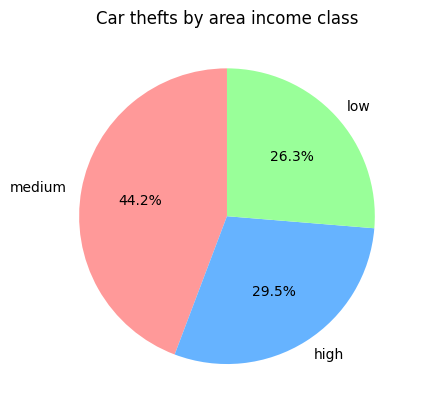

In [97]:
import matplotlib.pyplot as plt

premis_filtered['income_class'].value_counts().plot.pie(
    autopct='%1.1f%%', 
    startangle=90, 
    labels=premis_filtered['income_class'].value_counts().index,
    colors=['#ff9999','#66b3ff','#99ff99']
)
plt.ylabel('')
plt.title('Car thefts by area income class')
plt.show()

#### Here we see the distribution of car thefts happening dividing the areas into income classes. We see that the most happen in themedium income class, or the high income class which tracts as people steal nicer vehicles usaully.

In [98]:
crime_counts = premis_filtered.groupby("AREA NAME").size()

mean_income = premis_filtered.groupby("AREA NAME")["B19013_001E"].mean()

crime_income_ratio = (crime_counts / mean_income).to_dict()
premis_filtered['crime_income_ratio'] = premis_filtered['AREA NAME'].map(crime_income_ratio)

premis_filtered[['AREA NAME', 'crime_income_ratio']].drop_duplicates().sort_values('crime_income_ratio', ascending=False)


,AREA NAME,crime_income_ratio
449,77th Street,0.427611
66,Newton,0.371737
16,Southeast,0.360188
3451,Southwest,0.349113
26,Olympic,0.319125
563,Central,0.305318
612,Rampart,0.294232
2082,Hollenbeck,0.258715
972,Hollywood,0.255122
27,Mission,0.223812


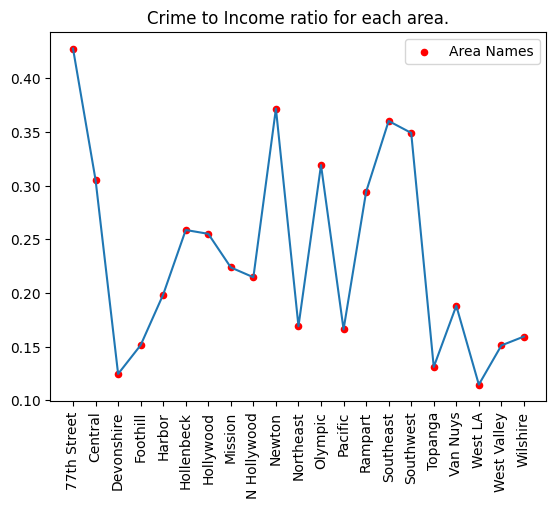

In [103]:
plt.plot(crime_income_ratio.keys(), crime_income_ratio.values())
plt.xticks(rotation=90)
plt.title('Crime to Income ratio for each area.')
plt.scatter(crime_income_ratio.keys(), crime_income_ratio.values(), color='red', s=20, label='Area Names')
plt.legend()

### here is a visual showing our second feature, crime to income ratio for each area. This helps us get a better understanding for each area showing the economic burden there is which could help influence crime rate.

last step we will drop columns we dont need and save this final dataset to use in our machine learning model.

In [102]:
premis_filtered.columns

Index(['DR_NO', 'Date Rptd', 'DATE OCC', 'TIME OCC', 'AREA', 'AREA NAME',
       'Rpt Dist No', 'Part 1-2', 'Crm Cd', 'Crm Cd Desc', 'Mocodes',
       'Vict Age', 'Vict Sex', 'Vict Descent', 'Premis Cd', 'Premis Desc',
       'Weapon Used Cd', 'Weapon Desc', 'Status', 'Status Desc', 'Crm Cd 1',
       'Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4', 'LOCATION', 'Cross Street', 'LAT',
       'LON', 'geometry', 'index_right', 'STATEFP', 'COUNTYFP', 'TRACTCE',
       'GEOID', 'GEOIDFQ', 'NAME_x', 'NAMELSAD', 'MTFCC', 'FUNCSTAT', 'ALAND',
       'AWATER', 'INTPTLAT', 'INTPTLON', 'NAME_y', 'B19013_001E', 'state',
       'county', 'tract', 'income_class', 'crime_income_ratio'],
      dtype='object')